In [ ]:
import requests
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from chembl_webresource_client.new_client import new_client

In [ ]:
# Initialize clients
activity = new_client.activity
assay = new_client.assay

In [ ]:
# Option 1: Search for assays containing HLM in their description
hlm_assays = assay.filter(assay_description__icontains='HLM').only('assay_chembl_id')
hlm_activities = activity.filter(assay_chembl_id__in=[a['assay_chembl_id'] for a in hlm_assays])
hlm_activities

In [ ]:
# Option 2: More specific filter for common HLM measurements
# (choose either Option 1 or 2 based on your needs)
hlm_activities = activity.filter(
    assay_description__icontains='HLM').filter(
    standard_type__in=['CL', 'T1/2', 'HLM_CL', 'HLM_clearance']  # common HLM measurement types
)

In [ ]:
# To get the molecules with HLM data (like your hERG example)
molecule = new_client.molecule
hlm_molecules = molecule.filter(
    molecule_chembl_id__in=list(set([act['molecule_chembl_id'] for act in hlm_activities]))
)

print(f"Found {len(hlm_activities)} HLM activities")
print(f"Found {len(hlm_molecules)} unique molecules with HLM data")

# You can then work with hlm_activities or hlm_molecules as needed

#### Extract hLM

In [15]:
assay = new_client.assay
activity = new_client.activity
molecule = new_client.molecule

In [61]:
assays = assay.filter(assay_type='A').only(['assay_type', 'description', 'assay_chembl_id', 'assay_organism'])[:10000]
df = pd.DataFrame(assays)

In [62]:
# Define regex pattern for HLM-related terms
pattern = r'(?i)\b(CL|microsome|HLM_CL|HLM_clearance|HLM_half_life|HLM_stability)\b'

hlm_df = df[df['description'].str.contains(pattern, na=False)]

/tmp/ipykernel_146621/1315703121.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  hlm_df = df[df['description'].str.contains(pattern, na=False)]


In [63]:
# Get all activities for these HLM assays
hlm_assay_ids = hlm_df['assay_chembl_id'].tolist()
activities = activity.filter(
    assay_chembl_id__in=hlm_assay_ids
).only([
    'molecule_chembl_id',
    'assay_chembl_id',
    'standard_value',  # The actual measurement value
    'standard_units',  # Units of measurement
    'standard_type',   # Type of measurement (CL, T1/2, etc.)
    'standard_relation',  # Relation to value (=, <, >, etc.)
    'document_chembl_id'
])
activities_df = pd.DataFrame(activities)
unique_molecule_ids = activities_df['molecule_chembl_id'].unique().tolist()

In [64]:
batch_size = 100
molecules = []
for i in range(0, len(unique_molecule_ids), batch_size):
    batch = unique_molecule_ids[i:i+batch_size]
    molecules.extend(molecule.filter(molecule_chembl_id__in=batch))

mols_df = pd.DataFrame(molecules)

In [65]:
full_data = pd.merge(activities_df, mols_df, on='molecule_chembl_id', how='left')
full_data = pd.merge(full_data, hlm_df, on='assay_chembl_id', how='left')
full_data = full_data[['assay_chembl_id', 'document_chembl_id', 'molecule_chembl_id', 'relation', 'standard_relation', 'standard_type', 
                       'standard_units', 'standard_value', 'type', 'units', 'value', 'assay_organism', 'molecule_structures', 'description']]

In [85]:
full_data['mol_smi'] = full_data['molecule_structures'].apply(lambda x: x.get('canonical_smiles') if isinstance(x, dict) else None)

In [88]:
filt = full_data['document_chembl_id'] == 'CHEMBL1121573'
tmp = full_data[filt]

In [90]:
PandasTools.AddMoleculeColumnToFrame(
    tmp, 
    smilesCol='mol_smi',  # Column containing SMILES strings
    molCol='Molecule',             # Name of new column to create
    includeFingerprints=False      # Set to True if you need fingerprints
)

/home/florent/Programs/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,assay_chembl_id,document_chembl_id,molecule_chembl_id,relation,standard_relation,standard_type,standard_units,standard_value,type,units,value,assay_organism,molecule_structures,description,mol_smi,Molecule
42,CHEMBL631130,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,1.54,Diuretic activity,None,1.54,Rattus norvegicus,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
43,CHEMBL631141,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,1.37,Diuretic activity,None,1.37,Rattus norvegicus,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
44,CHEMBL629219,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,1.56,Diuretic activity,None,1.56,Rattus norvegicus,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
45,CHEMBL631135,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,1.43,Diuretic activity,None,1.43,Rattus norvegicus,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
46,CHEMBL631146,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,8.57,Diuretic activity,None,8.57,Canis lupus familiaris,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
47,CHEMBL631444,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,22.0,Diuretic activity,None,22.0,Canis lupus familiaris,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
48,CHEMBL626396,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,26.3,Diuretic activity,None,26.3,Canis lupus familiaris,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
49,CHEMBL631150,CHEMBL1121573,CHEMBL435,=,=,Diuretic activity,None,22.9,Diuretic activity,None,22.9,Canis lupus familiaris,{'canonical_smiles': 'NS(=O)(=O)c1cc2c(cc1Cl)N...,Oral diuretic activity was evaluated by measur...,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,
50,CHEMBL631132,CHEMBL1121573,CHEMBL558781,=,=,Diuretic activity,None,1.25,Diuretic activity,None,1.25,Rattus norvegicus,{'canonical_smiles': 'COc1c(Cl)c(O)c(CN)c(OC)c...,Oral diuretic activity was evaluated by measur...,COc1c(Cl)c(O)c(CN)c(OC)c1Cl.Cl,
51,CHEMBL631143,CHEMBL1121573,CHEMBL558781,=,=,Diuretic activity,None,2.36,Diuretic activity,None,2.36,Rattus norvegicus,{'canonical_smiles': 'COc1c(Cl)c(O)c(CN)c(OC)c...,Oral diuretic activity was evaluated by measur...,COc1c(Cl)c(O)c(CN)c(OC)c1Cl.Cl,

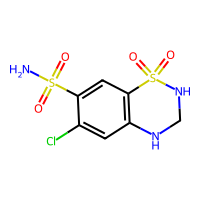
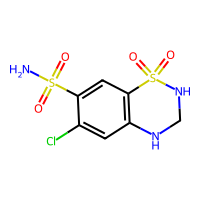
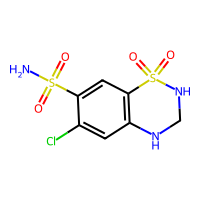
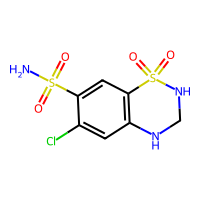
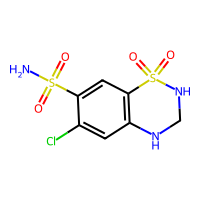
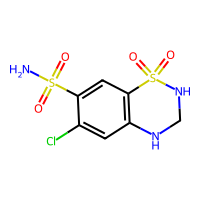
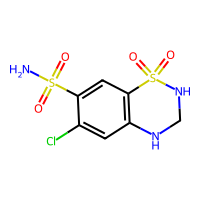
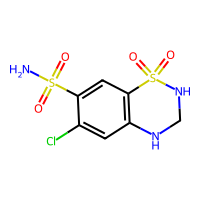
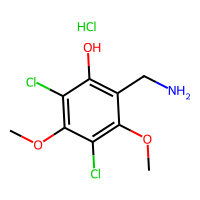
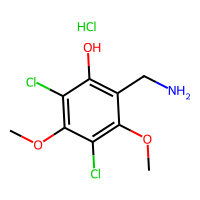
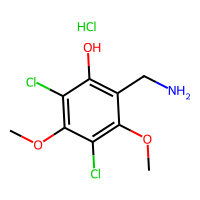
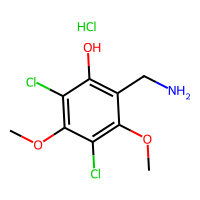
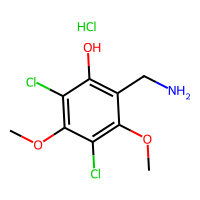
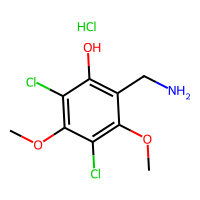
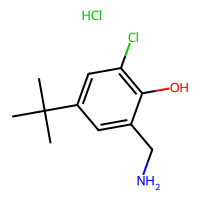
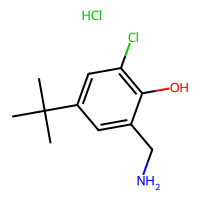
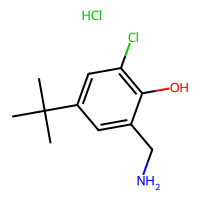
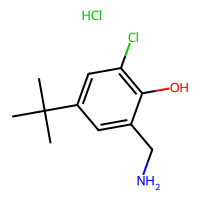
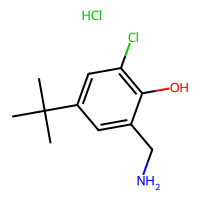
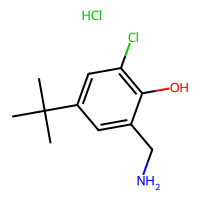
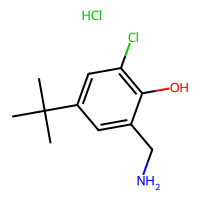
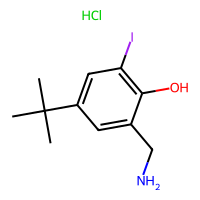
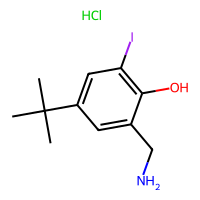
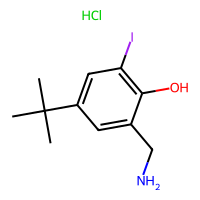
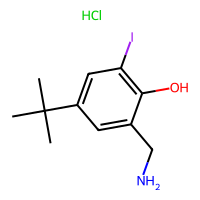
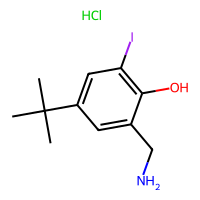
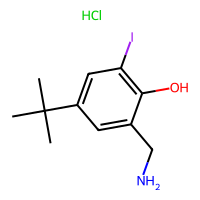
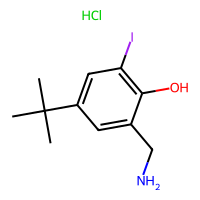
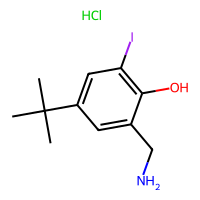
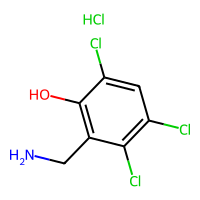
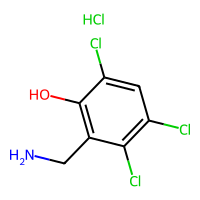
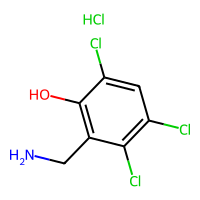
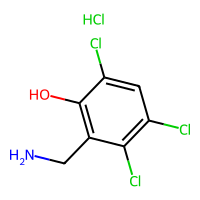
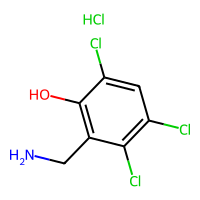
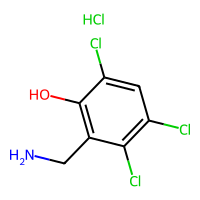
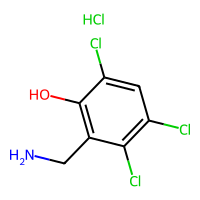
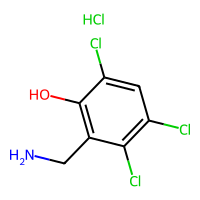
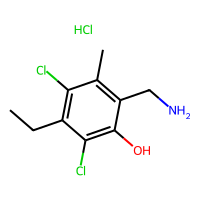
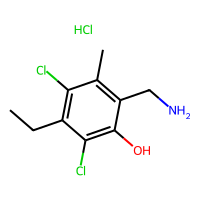
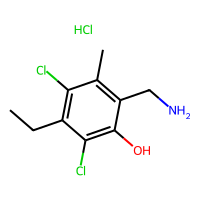
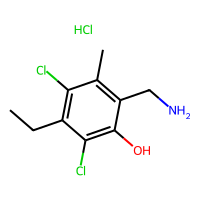
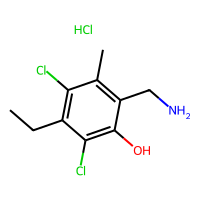
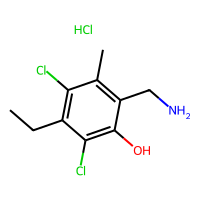
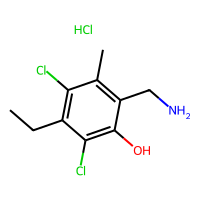
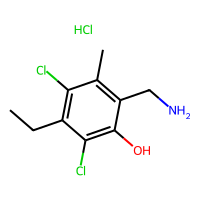
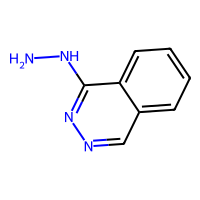
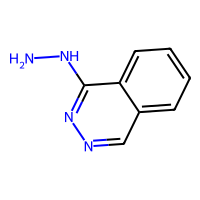
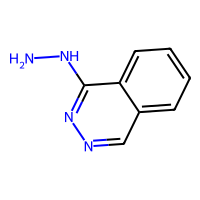
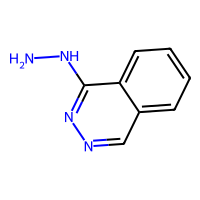
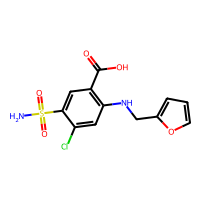
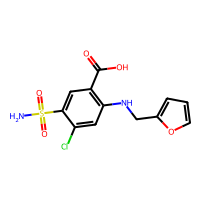
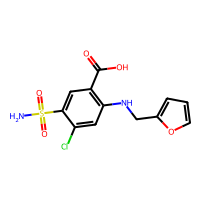
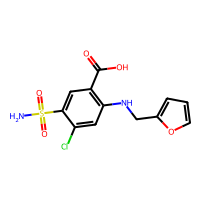
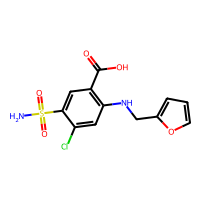
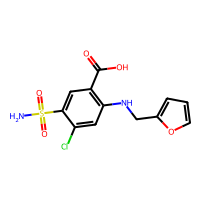

In [91]:
tmp

In [71]:
# CHEMBL1121573

#### Plot

([0, 1, 2, 3],
 [Text(0, 0, 'CL'),
  Text(1, 0, 'CL/F'),
  Text(2, 0, 'Diuretic activity'),
  Text(3, 0, 'T1/2')])

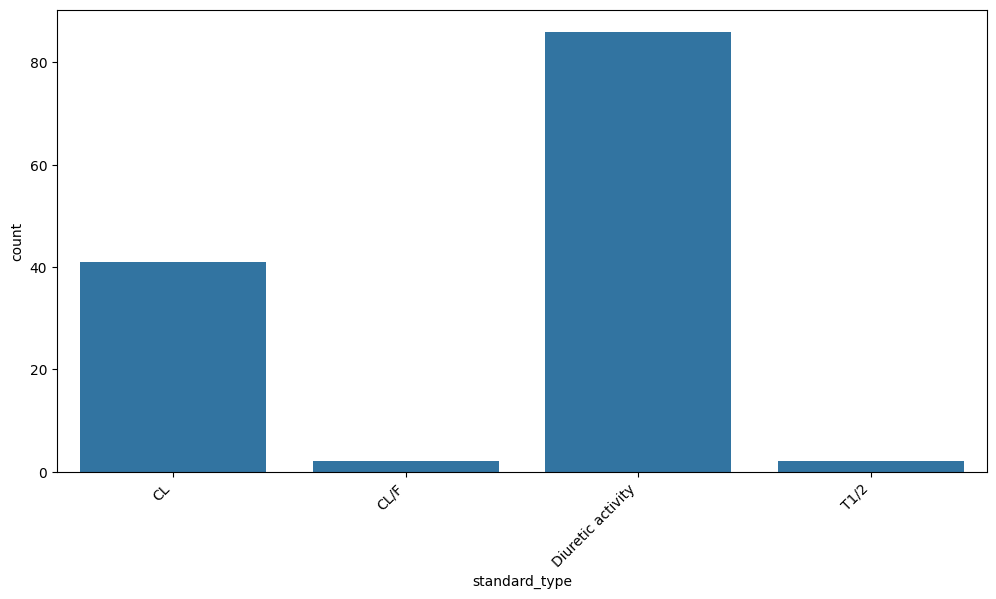

In [80]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(multi_molecule_data, x='standard_type')
plt.xticks(rotation=45, ha='right') 

#### Extract hERG

In [ ]:
from chembl_webresource_client.new_client import new_client

target = new_client.target
activity = new_client.activity
herg = target.filter(pref_name__iexact='hERG').only('target_chembl_id')[0]
herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']).filter(standard_type="IC50")

herg_activities

#### Extract HLM data

In [ ]:
def fetch_metabolic_assays(limit=1000):
    url = f"https://www.ebi.ac.uk/chembl/api/data/assay.json?assay_type=ADME&limit={limit}"
    assays = []
    while url:
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        for a in data["assays"]:
            if "metabolic" in (a.get("description") or "").lower():
                assays.append(a["assay_chembl_id"])
        url = data["page_meta"]["next"]
    return assays

def fetch_activities_for_assays(assay_ids, limit=1000):
    activities = []
    for assay_id in assay_ids:
        url = f"https://www.ebi.ac.uk/chembl/api/data/activity.json?assay_chembl_id={assay_id}&limit={limit}"
        while url:
            res = requests.get(url)
            res.raise_for_status()
            data = res.json()
            activities.extend(data["activities"])
            url = data["page_meta"]["next"]
    return activities

In [ ]:
assay_ids = fetch_metabolic_assays()
print(f"Found {len(assay_ids)} assays likely related to metabolic stability.")

activities = fetch_activities_for_assays(assay_ids[:5])  # You can increase the slice
print(f"Retrieved {len(activities)} activity records.")

#### Get molecules w/ logP

In [ ]:
def fetch_molecules_with_logp_and_docs(limit=100, max_pages=None, verbose=True):
    url = f"{base_url}/chembl/api/data/molecule.json?logp__isnull=false&molecule_documents__isnull=false&limit={limit}"
    molecules = []
    page = 0
    
    while url and (max_pages is None or page < max_pages):
        if verbose:
            print(f"Fetching page {page + 1}...")
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        molecules.extend(data['molecules'])

        next_url = data['page_meta']['next']
        url = f"{base_url}{next_url}" if next_url else None
        page += 1

    return molecules

In [ ]:
molecules = fetch_molecules_with_logp_and_docs(limit=50, max_pages=1)

with open("../data/raw/chembl_logP_molecules.json", "w") as f:
    json.dump(molecules, f, indent=2)

print(f"Fetched {len(molecules)} molecules with logP.")

In [ ]:
df = pd.DataFrame(molecules)
df.columns

In [ ]:
df = df[['molecule_structures', 'molecule_chembl_id', 'molecule_properties']]
df.head(2)

In [ ]:
# Test API with a known molecule Chembl ID
chembl_id = "CHEMBL6329"
url = f"https://www.ebi.ac.uk/chembl/api/data/document.json?molecule_chembl_id={chembl_id}"
res = requests.get(url)
res.raise_for_status()
data = res.json()
documents = data.get("documents", [])
df = pd.DataFrame(documents)
df.head(1)

In [ ]:
# Get all activities in CHemBL 
url = "https://www.ebi.ac.uk/chembl/api/data/activity.json?limit=1000"
res = requests.get(url)
res.raise_for_status()
data = res.json()

types = {a["standard_type"] for a in data["activities"] if a.get("standard_type")}
types = sorted(types)
for t in types:
    print(t)

#### Get document_id for subset

In [ ]:
# Function to fetch documents associated with a molecule
def get_documents_for_molecule(chembl_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/document.json?molecule_chembl_id={chembl_id}"
    res = requests.get(url)
    res.raise_for_status()
    return res.json().get("documents", [])

In [ ]:
chembl_id = "CHEMBL25"
documents = get_documents_for_molecule(chembl_id)
documents

In [ ]:
# Add document IDs to each molecule
def fetch_documents_for_molecules(molecules):
    doc_map = {}
    for mol in molecules:
        chembl_id = mol.get("molecule_chembl_id")
        if chembl_id:
            docs = get_documents_for_molecule(chembl_id)
            doc_ids = [d["document_chembl_id"] for d in docs]
            doc_map[chembl_id] = doc_ids
    return doc_map

In [ ]:
doc_map = fetch_documents_for_molecules(molecules)

In [ ]:
doc_map

In [ ]:
df = pd.DataFrame(molecules)

In [ ]:
df["logP"] = df["molecule_properties"].apply(
    lambda x: x.get("alogp") if isinstance(x, dict) else None
)

In [ ]:
df["document_ids"] = df["molecule_chembl_id"].map(doc_map)

# Show merged DataFrame
df_merged = df[["molecule_chembl_id", "logP", "document_ids"]]
print(df_merged.head())

#### Get molecules from document_id

In [ ]:
def get_molecules_for_document(document_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule_document.json?document_chembl_id={document_id}"
    res = requests.get(url)
    res.raise_for_status()
    return res.json().get("molecule_documents", [])

In [ ]:
# Example: Get molecules associated with a document
document_id = "CHEMBL1158643"
molecule_docs = get_molecules_for_document(document_id)

# Print out the molecule ChEMBL IDs
molecule_ids = [doc["molecule_chembl_id"] for doc in molecule_docs]
print(f"Molecule ChEMBL IDs for document {document_id}: {molecule_ids}")

In [ ]:
def fetch_molecules_with_logp_and_patents(limit=100, max_pages=None, verbose=True):
    base_url = "https://www.ebi.ac.uk"
    url = f"{base_url}/chembl/api/data/molecule.json?logp__isnull=false&molecule_patents__isnull=false&limit={limit}"
    molecules = []
    page = 0

    while url and (max_pages is None or page < max_pages):
        if verbose:
            print(f"Fetching page {page + 1}...")
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        molecules.extend(data['molecules'])

        next_url = data['page_meta'].get('next')
        url = f"{base_url}{next_url}" if next_url else None
        page += 1

    return molecules

def fetch_molecules_with_logp_smiles_and_patents(limit=100, max_pages=None, verbose=True):
    base_url = "https://www.ebi.ac.uk"
    url = f"{base_url}/chembl/api/data/molecule.json?logp__isnull=false&molecule_patents__isnull=false&limit={limit}"
    molecules = []
    page = 0

    while url and (max_pages is None or page < max_pages):
        if verbose:
            print(f"Fetching page {page + 1}...")
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()
        molecules.extend(data['molecules'])

        next_url = data['page_meta'].get('next')
        url = f"{base_url}{next_url}" if next_url else None
        page += 1

    # Fetch SMILES and Patent IDs for each molecule
    molecules_with_smiles_and_patents = []
    for molecule in molecules:
        patent_ids = []
        smiles = None
        
        # Get SMILES from molecule_structures
        if 'molecule_structures' in molecule:
            smiles = molecule['molecule_structures'].get('canonical_smiles', None)
        
        # Get patent IDs from molecule_patents
        if 'molecule_patents' in molecule:
            patent_ids = [patent['patent_chembl_id'] for patent in molecule['molecule_patents']]
        
        # Add SMILES and patent IDs to molecule data
        molecule['smiles'] = smiles
        molecule['patent_ids'] = patent_ids
        molecules_with_smiles_and_patents.append(molecule)

    return molecules_with_smiles_and_patents